In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Instalações

A seguir serão instaladas algumas bibliotecas necessárias para a execução do projeto.
Além dos framesworks comuns, serão também considerados outros como pandas.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
# importando o dataset para o ambiente do colab
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

# Importações

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict


# Pré-processamento

O modulo transforms do torchvision nos permite realizar algumas transformações nas imagens como rotacao e corte de diferentes maneiras. Será definido transformações diferentes no conjunto de treino e teste. OBS: o conjuto de validação aqui foi retirado do conjunto de treino e a pasta 'valid' foi deixada para teste.

In [0]:
# transformações para treino e teste
train_transforms = transforms.Compose([transforms.RandomRotation(80),  
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(), # flip horizontal
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                      ])
test_transforms =  transforms.Compose([transforms.Resize(260),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                      ])

In [0]:
# carregando conjunto de treino
train_set = datasets.ImageFolder('/content/flower_data/train', transform=train_transforms)
# carregando conjuto de teste
test_set  = datasets.ImageFolder('/content/flower_data/valid', transform=test_transforms)

In [0]:
def val_prepare(val_size):
    # preparando conjunto de validação
    data_points = len(train_set)
    indices = list(range(data_points))
    np.random.shuffle(indices)
    split = int(np.floor(val_size * data_points))
    train_idx, valid_idx = indices[split:], indices[:split]
    return SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

Para a manipulação do arquivo 'cat_to_name.json' será utilizada bibliotaca pandas. O objetivo é ordenar as classes para acessa-las posteriormente pelos indices, esses indices serão coincidentes com os números de cada classe. 

In [0]:
def trat_classes(train_loader):
    # carregado arquivo
    classes = pd.read_json('/content/cat_to_name.json', lines=True)
    # ordenado as classes em uma lista
    classes_ordenadas =['none'] # não existe pasta nomeada 0
    for i in range(1, 103):
        classes_ordenadas.append(classes[i].item())
        
    # aproveirando  e printando algumas imagens
    
    # escolhendo um lote do conjuto de treino
    images, labels = next(iter(train_loader))
    # visualizando
    fig = plt.figure(figsize=(14,4));
    for i in range(1, 5):
        ax = fig.add_subplot(1, 5/1, i+1, xticks=[], yticks=[]);
        ax.imshow(np.squeeze(images[i].numpy().transpose((1, 2, 0))))
        ax.set_title('({})'.format(classes_ordenadas[labels[i]]))        
    
    return classes_ordenadas

In [0]:
tSamp, vSamp = val_prepare(0.2)

# dataloaders
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=32, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_set, sampler=tSamp, batch_size=32)
valid_loader = torch.utils.data.DataLoader(train_set, sampler=vSamp, batch_size=32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


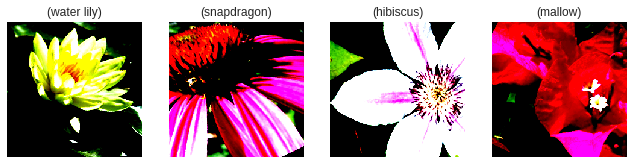

In [0]:
# visulizando imagens e ordenando classes
classes = trat_classes(train_loader)

In [0]:
classes[1]

'pink primrose'

# Criando rede

In [0]:
# ecolhendo a arquitetura resnet18 como modelo para transferencia de aprendizado
model = models.resnet34(pretrained=True) 

In [0]:
model.fc # substituir o numero de classes no out_feature

Linear(in_features=512, out_features=1000, bias=True)

In [0]:
classifier = nn.Sequential(OrderedDict([
                           ('fc', nn.Linear(512, 102))
                           ]))

In [0]:
# congelando as camadas convolucionais
for weights in model.parameters():
    weights.requires_grad = False

In [0]:
model.fc = classifier # substituindo a camada totoalmente conectada
criterio = nn.CrossEntropyLoss() # função de custo ideal para o uso da funcao de activação softmax
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) 

In [0]:
# testando se a GPU está disponível
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

# Fase de treinamento

In [0]:
def validar(valid_loss):
    model.eval() # setando para modo de validaçao
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        loss = criterio(output, labels)
        valid_loss += loss.item()*images.size(0)
            
    valid_loss = valid_loss/len(valid_loader.dataset)
    return valid_loss

In [0]:
def treinar(train_loss):
    model.train() # setando modelo para treinamento
    for data, target in train_loader:
        data, target = data.to(device), target.to(device) # movendo tensors para GPU
        optimizer.zero_grad() 
        output = model.forward(data)

        loss = criterio(output, target)
        loss.backward()
        optimizer.step()
            
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    return train_loss
            
  

In [0]:

val, train = [], [] 
def aprender(epochs):
    valid_loss_min = np.inf
    comeco = time.time() # tempo de treinamento
    remain_ep = epochs
    for ep in range(epochs):
        train_loss = 0.0 
        valid_loss = 0.0
        remain_ep -= 1
        
        train_loss = treinar(train_loss)
        valid_loss = validar(valid_loss)
            
        
        
        # salvando perdas para plotar posteriormente
        train.append(train_loss)
        val.append(valid_loss)
        
        
        tempo_treino = time.time() - comeco # tempo de treinamento
        if ep == 0:
          tempo_epoch = (tempo_treino // 60) # tempo de cada epoca
          
        print('tempo de treinamento {:.0f}m {:.0f}s    tempo esperado: {:.0f} minutos'.format(tempo_treino // 60, tempo_treino % 60, tempo_epoch*remain_ep))
        print('epoch: {} \t train_loss: {:.7f} \t valid_loss: {:.7f}'.format(ep+1, train_loss, valid_loss))
        
        if valid_loss <= valid_loss_min:
            print('salvando modelo...')
            torch.save(model.state_dict(), 'final_resnet18_trained.pt')
            valid_loss_min = valid_loss
    
            

In [0]:
 aprender(40) # aprendendo...

tempo de treinamento 2m 30s    tempo esperado: 78 minutos
epoch: 1 	 train_loss: 2.6048895 	 valid_loss: 0.4093955
salvando modelo...
tempo de treinamento 4m 57s    tempo esperado: 76 minutos
epoch: 2 	 train_loss: 1.3379869 	 valid_loss: 0.2617597
salvando modelo...
tempo de treinamento 7m 24s    tempo esperado: 74 minutos
epoch: 3 	 train_loss: 0.9136407 	 valid_loss: 0.1964748
salvando modelo...
tempo de treinamento 9m 51s    tempo esperado: 72 minutos
epoch: 4 	 train_loss: 0.7423065 	 valid_loss: 0.1778448
salvando modelo...
tempo de treinamento 12m 18s    tempo esperado: 70 minutos
epoch: 5 	 train_loss: 0.6554675 	 valid_loss: 0.1633979
salvando modelo...
tempo de treinamento 14m 45s    tempo esperado: 68 minutos
epoch: 6 	 train_loss: 0.5821027 	 valid_loss: 0.1485930
salvando modelo...
tempo de treinamento 17m 12s    tempo esperado: 66 minutos
epoch: 7 	 train_loss: 0.5325687 	 valid_loss: 0.1352363
salvando modelo...
tempo de treinamento 19m 40s    tempo esperado: 64 minutos


# Inferência

In [0]:
# visulizar testes
def image_show(model):
    model.to('cpu')
    images, labels = next(iter(test_loader))
    out = model(images)
    pred = torch.max(out, 1)[1]
   
    fig = plt.figure(figsize=(25,4));
    for idx in np.arange(10):
        # desnormalizando imagens
        aux = images[idx].numpy() / 2 + 0.5
        ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[]);
        ax.imshow(np.squeeze(aux.transpose((1, 2, 0))));
        ax.set_title('{} = [{}]'.format(classes[pred[idx].item()], classes[int(labels[idx])]))
    

In [0]:
def train_val_plot(train, val):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(221)
    ax.plot(train)
    ax.set_title('train loss');
    ax = fig.add_subplot(222)
    ax.plot(val,'r')
    ax.set_title('validation loss',);
    ax = fig.add_subplot(223)
    ax.plot(train, 'b')
    ax.plot(val, 'r')
    ax.set_title('train and validation')


In [0]:
def accuracy(model):
    model.to(device)
    test_loss = 0.0
    # listas com 102 elementos 0 do tipo float
    correct_classes = list(np.zeros(102)) 
    all_classes = list(np.zeros(102))
    
    model.eval() 
    for data, target in test_loader:
        data, target = data.to(device), target.to(device) # movendo para GPU
        # propagação
        output = model(data)
        loss = criterio(output, target)
    
        test_loss += loss.item()*data.size(0)
    
        prediction = torch.max(output, 1)[1] # predição de classes
        correct = prediction == target       # comparação booleana com os rotulos
        for i in range(target.shape[0]):     # iterando sob todas as imagens no lote
          label = target.data[i]            
          
          correct_classes[label] += correct[i].item()
          all_classes[label] += 1
    
    
    test_loss = test_loss / len(test_loader.dataset)
    print('test_loss : {:.6f}'.format(test_loss))  
  
    # metrica accurácia : classes corretamente classificadas sobre todas as classes
    print('total accuracy : {:.2f}'.format(np.sum(correct_classes) / np.sum(all_classes)))
    
  

In [0]:
model.load_state_dict(torch.load('/content/final_resnet18_trained.pt')) # carrengando melhor modelo

In [0]:
accuracy(model) #calculando accurácia

test_loss : 0.272365
total accuracy : 0.93


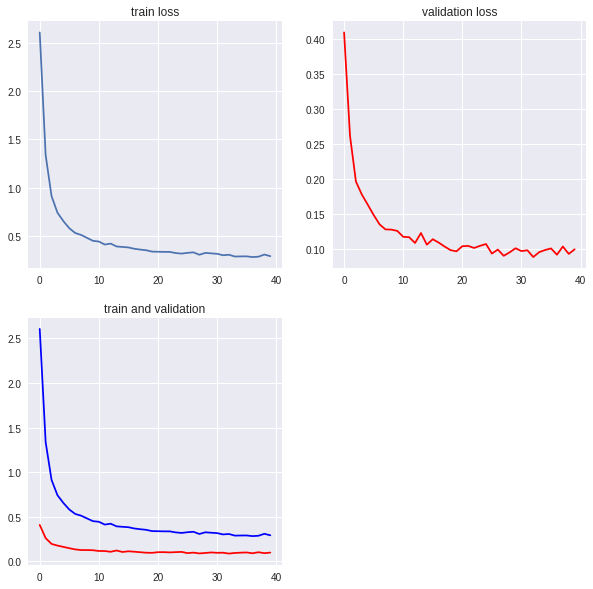

In [0]:
train_val_plot(train, val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

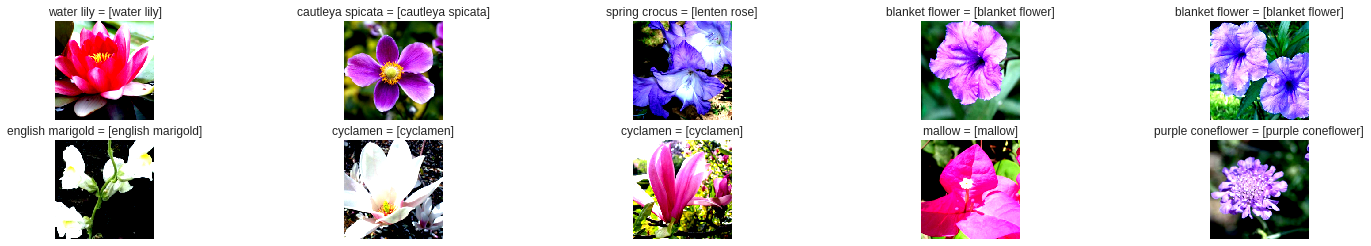

In [0]:
image_show(model)